# Project - Deploying a Machine Learning Model on Heroku with FastAPI

## Data Description

### Source

This data was extracted from the census bureau database found at http://www.census.gov/ftp/pub/DES/www/welcome.html
```
Donor: Ronny Kohavi and Barry Becker,
       Data Mining and Visualization
       Silicon Graphics.
       e-mail: ronnyk@sgi.com for questions.
```
* Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
* 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
* 45222 if instances with unknown values are removed (train=30162, test=15060)
* Duplicate or conflicting instances : 6
* Class probabilities for adult.all file
  * Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
  * Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)

For this project, only __train set__ of __unfiltered instanes__ is used - __32561 instances__.

### Objective
Prediction task is to determine whether a person makes over 50K a year.


### Transformations
Conversion of original data as follows:
1. Discretized gross income into two ranges with threshold 50,000.
2. Convert U.S. to US to avoid periods.
3. Convert Unknown to "?"
4. Run MLC++ GenCVFiles to generate data,test.


### Description of fnlwgt (final weight)
The weights on the CPS files are controlled to independent estimates of the
civilian noninstitutional population of the US.  These are prepared monthly
for us by Population Division here at the Census Bureau.  We use 3 sets of
controls.
These are:
1. A single cell estimate of the population 16+ for each state.
2. Controls for Hispanic Origin by age and sex.
3. Controls by Race, age and sex.
We use all three sets of controls in our weighting program and "rake" through
them 6 times so that by the end we come back to all the controls we used.
The term estimate refers to population totals derived from CPS by creating
"weighted tallies" of any specified socio-economic characteristics of the
population.

People with similar demographic characteristics should have
similar weights.  There is one important caveat to remember
about this statement.  That is that since the CPS sample is
actually a collection of 51 state samples, each with its own
probability of selection, the statement only applies within
state.

### Data values
| name | values |
|------|--------|
| __salary__ | >50K, <=50K.|
| age | continuous |
| workclass | Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked |
| fnlwgt | continuous |
| education | Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool |
| education-num | continuous |
| marital-status | Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse |
| occupation | Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces |
| relationship | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried |
| race | White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black |
| sex | Female, Male |
| capital-gain | continuous |
| capital-loss | continuous |
| hours-per-week | continuous |
| native-country | United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands |

## Getting raw data

In [1]:
import pandas as pd

In [2]:
DATA_PATH = '../data/census.csv'
df = pd.read_csv(DATA_PATH)
df.head()

,age,workclass,fnlgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Initial ETL

### Remove trailing spaces

In [3]:
print(f'Trailing spaces: \n{df.columns.tolist()[:5]} ...')
def trim(dataset: pd.DataFrame, asdf: float = 0.0):
    dataset.columns = [col.strip() for col in dataset.columns]
    dataset.columns = [col.replace('-', '_') for col in dataset.columns]

    return dataset.applymap(
        lambda value: value.strip() if isinstance(value, str) else value)

df = trim(df)
print(f'Removing spaces: \n{df.columns.tolist()[:5]} ...')

Trailing spaces: 
['age', ' workclass', ' fnlgt', ' education', ' education-num'] ...
Removing spaces: 
['age', 'workclass', 'fnlgt', 'education', 'education_num'] ...


### Replace `?` with `Unknown` for readability

In [4]:
def mark_question_row(row):
    return row.astype(str).str.contains('?', regex=False).any()

df.loc[df.apply(mark_question_row, axis=1)].head()

,age,workclass,fnlgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,>50K
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
38,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,?,>50K
51,18,Private,226956,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,30,?,<=50K
61,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K


In [5]:
print(f'Number of rows containing `?`: {df.apply(mark_question_row, axis=1).sum()}')
df.replace({'?': 'Unknown'}, inplace = True)
print(f'Number of rows containing `?` after replacement: {df.apply(mark_question_row, axis=1).sum()}')


Number of rows containing `?`: 2399
Number of rows containing `?` after replacement: 0


### Remove duplicate rows

In [6]:
df[df.duplicated(keep = False)].sort_values('fnlgt').head()

,age,workclass,fnlgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
28846,39,Private,30916,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
25624,39,Private,30916,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
21875,49,Private,31267,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
7920,49,Private,31267,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
22494,49,Self-emp-not-inc,43479,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K


In [7]:
print(f'Number of rows: {df.shape[0]}')
df.drop_duplicates(inplace = True)
print(f'Number of rows after duplicates drop: {df.shape[0]}')

Number of rows: 32561
Number of rows after duplicates drop: 32537


## `pandas_profiling` for initial EDA

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile

## ETL (for baseline)

In [8]:
RANDOM_STATE = 48
TEST_SIZE = 0.2

### Columns' types

`education` and `education-num` have Pearson's correlation of 1.0, but `education_num` has ordinal information.

cat_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
num_features = ['age', 'fnlgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
target = 'salary'

df = df[cat_features + num_features + [target]]

### Ordinal columns' order

In [10]:
workclass_order = ['Private', 'Self-emp-inc', 'Self-emp-not-inc', 'Local-gov', 'State-gov', 'Federal-gov', 'Without-pay', 'Never-worked', 'Unknown', 'Other']
education_order = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate', 'Other']
marital_status_order = ['Married-civ-spouse', 'Married-AF-spouse', 'Married-spouse-absent', 'Separated', 'Divorced', 'Widowed', 'Never-married', 'Other']
relationship_order = ['Husband', 'Wife', 'Own-child', 'Unmarried', 'Not-in-family', 'Other-relative', 'Other']

cat_order = {
    'workclass': workclass_order,
    'education': education_order,
    'marital_status': marital_status_order,
    'occupation': None,
    'relationship': relationship_order,
    'race': None,
    'sex': None,
    'native_country': None
}

### Transforming independent variables

In [11]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


categorical = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
categorical_preproc = OneHotEncoder(sparse=False, handle_unknown='ignore')

zero_imputed = ['fnlgt', 'capital_gain', 'capital_loss']
zero_imputer = SimpleImputer(strategy='constant', fill_value=0)

median_imputed = ['hours_per_week']
median_imputer = SimpleImputer(strategy='median')

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_preproc, categorical),
        ('zero_imputed', zero_imputer, zero_imputed),
        ('median_imputed', median_imputer, median_imputed)
    ],
    remainder='passthrough',
)

X = preprocessor.fit_transform(df[num_features + cat_features])
print(f'Transformed data shape: {X.shape}')

target_preprocessor = LabelEncoder()
y = target_preprocessor.fit_transform(df[target].values)


for i, c in enumerate(target_preprocessor.classes_):
    print(f'Label `{c}` encoded into: `{i}`')
print(f'Transformed target shape: {y.shape}')


Transformed data shape: (32537, 108)
Label `<=50K` encoded into: `0`
Label `>50K` encoded into: `1`
Transformed target shape: (32537,)


## Baseline model(s)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, stratify = y, random_state = RANDOM_STATE)

### Gradient Boosting classifier (sklearn)

F1 beta score        : 0.694
Precision (PPV) score: 0.776
Recal (TPR) score    : 0.628


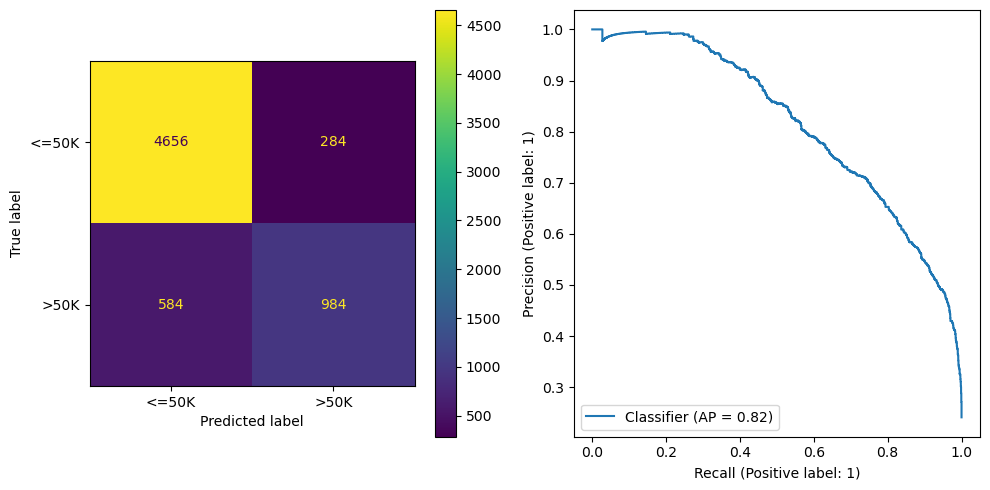

In [14]:
from sklearn.metrics import fbeta_score, precision_score, recall_score, ConfusionMatrixDisplay, PrecisionRecallDisplay

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state = RANDOM_STATE)
gbc.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = gbc.predict(X_test)
y_pred_proba = gbc.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_preprocessor.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

#### Testing exporting and loading model and running inference

In [15]:
from joblib import dump, load
MODEL_PATH = 'model_pipeline.joblib'

model_pipeline = {
    'ind_features': num_features + cat_features,
    'target': target,
    'preprocessor': preprocessor,
    'target_preprocessor': target_preprocessor,
    'classifier': gbc
}

dump(model_pipeline, MODEL_PATH)

['model_pipeline.joblib']

In [ ]:
model = load(MODEL_PATH)

_, X_test, _, y_test = train_test_split(
    df[model['cat_features'] + model['num_features']],
    df[model['target']],
    test_size = TEST_SIZE,
    stratify = df[model['target']],
    random_state = RANDOM_STATE)

X_cat = model['cat_encoder'].transform(
    X_test[model['cat_features']].values)
X_num = X_test[model['num_features']].values
X_test = np.concatenate([X_num, X_cat], axis=1)

y_test = model['target_encoder'].transform(y_test.values)

pred = model['classifier'].predict(X_test)
y_pred_proba = model['classifier'].predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

### AdaBoost classifier (sklearn)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(random_state = RANDOM_STATE)
abc.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = abc.predict(X_test)
y_pred_proba = abc.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

### Random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = RANDOM_STATE)
rfc.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = rfc.predict(X_test)
y_pred_proba = rfc.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

### Logistic regression classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state = RANDOM_STATE)
lr.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

### Catboost - does not require preprocessing of categorical variables

#### ETL for catboost

In [ ]:
y = df[target]
X = df.loc[:, df.columns != target]

y = target_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = RANDOM_STATE)

#### Model training

In [ ]:
from catboost import CatBoostClassifier


cbc = CatBoostClassifier(
    cat_features = cat_features,
    random_seed = RANDOM_STATE,
    verbose = False)

# train the model
cbc.fit(X_train, y_train)

# make the prediction using the resulting model
y_pred = cbc.predict(X_test)
y_pred_proba = cbc.predict_proba(X_test)

fbeta = fbeta_score(y_test, y_pred, beta=1, zero_division=1)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)

print(f'F1 beta score        : {fbeta:.3f}')
print(f'Precision (PPV) score: {precision:.3f}')
print(f'Recal (TPR) score    : {recall:.3f}')

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels = target_encoder.classes_,
    ax = axes[0]
)

PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba[:, 1],
    ax = axes[1]
)

plt.tight_layout()
plt.show()

## EDA

### Target feature plots

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

#### Categorical variables - Plots without percentile filtration

In [ ]:
fig, axes = plt.subplots((len(cat_features) + 2) // 3, 3, figsize = (20, 20))

for i, cat_f in enumerate(cat_features):
    ix = i % 3
    iy = i // 3
    sns.countplot(
        data = df,
        y = cat_f,
        hue = target,
        ax = axes[iy, ix],
        order = cat_order[cat_f]
    )

plt.tight_layout()
plt.show()


#### Categorical variables - Plots with percentile filtration

In [ ]:
def _transform_get_percentile(df, cat_f, target, percentile = 0.95):
    
    tmp_df = df[[cat_f, target]].copy(deep = True)
    value_counts = tmp_df[cat_f].value_counts()
    within_percentile = value_counts[value_counts.cumsum() <= percentile * tmp_df.shape[0]].index.tolist()
    tmp_df[cat_f] = tmp_df[cat_f].map(lambda x: x if x in within_percentile else 'Other')

    return tmp_df


fig, axes = plt.subplots((len(cat_features) + 2) // 3, 3, figsize = (20, 15))

for i, cat_f in enumerate(cat_features):
    tmp_df = _transform_get_percentile(df, cat_f, target)
    ix = i % 3
    iy = i // 3
    tmp_order = [v for v in cat_order[cat_f] if v in tmp_df[cat_f].unique()] \
                if cat_order[cat_f] is not None else None
    sns.countplot(
        data = tmp_df,
        y = cat_f,
        hue = target,
        ax = axes[iy, ix],
        order = tmp_order
    )

plt.tight_layout()
plt.show()


#### Numeric variables

In [ ]:
fig, axes = plt.subplots((len(num_features) + 2) // 3, 3, figsize = (20, 10))

for i, num_f in enumerate(num_features):
    ix = i % 3
    iy = i // 3
    sns.kdeplot(
        data = df, 
        x = num_f,
        hue = target,
        ax = axes[iy, ix],
        fill=True
    )


plt.tight_layout()
plt.show()


### Independent variables plots

#### `age`

In [ ]:
sns.catplot(
    x = 'age',
    y = 'occupation',
    hue = target,
    kind = 'box',
    data = df
)

plt.tight_layout()
plt.show()

In [ ]:
age = df['age']
assert age.between(17, 90).all()
age.hist(bins = 74)
plt.show()

In [ ]:
sns.catplot(
    x='age',
    y='salary',
    kind='violin',
    data=df
 )
plt.show()

In [ ]:
sns.catplot(
    x='age',
    y='salary',
    kind='box',
    data=df
 )
plt.show()

#### `workclass`

In [ ]:
workclass = df['workclass']
workclass.value_counts()

#### `fnlgt`

In [ ]:
fnlgt = df['fnlgt']
pd.DataFrame(data = {'10 largest': fnlgt.nlargest(10).values, '10 smallest': fnlgt.nsmallest(10).values})

In [ ]:
fnlgt.hist(bins = 50)
plt.show()

#### `education`

In [ ]:
education = df['education']
education.value_counts()

#### `education_num`

In [ ]:
education_num = df['education_num']
education_num.value_counts()

#### `marital_status`

In [ ]:
marital_status = df['marital_status']
marital_status.value_counts()

#### `occupation`

In [ ]:
occupation = df['occupation']
occupation.value_counts()

#### `relationship`

In [ ]:
relationship = df['relationship']
relationship.value_counts()

#### `race`

In [ ]:
race = df['race']
race.value_counts()

#### `sex`

In [ ]:
sex = df['sex']
sex.value_counts()

#### `capital_gain`

In [ ]:
capital_gain = df['capital_gain']
pd.DataFrame(data = {'10 largest': capital_gain.nlargest(10).values, '10 smallest': capital_gain.nsmallest(10).values})

In [ ]:
capital_gain[(capital_gain != 0) & (capital_gain != 99999)].hist(bins = 50)
plt.show()

#### `capital_loss`

In [ ]:
capital_loss = df['capital_loss']
pd.DataFrame(data = {'10 largest': capital_loss.nlargest(10).values, '10 smallest': capital_loss.nsmallest(10).values})

In [ ]:
capital_loss[capital_loss != 0].hist(bins = 50)
plt.show()

#### `hours_per_week`

In [ ]:
hours_per_week = df['hours_per_week']
pd.DataFrame(data = {'10 largest': hours_per_week.nlargest(10).values, '10 smallest': hours_per_week.nsmallest(10).values})

In [ ]:
hours_per_week.hist(bins = 40)
plt.show()

#### `native_country`

In [ ]:
native_country = df['native_country']
native_country.value_counts()

## Model bias

### Preprocessing

In [ ]:
y = df[target]
X = df.loc[:, df.columns != target]

y = target_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = RANDOM_STATE)

df_aq = X_test.copy(deep = True)

In [ ]:
df_aq['label_value'] = y_test
df_aq['score'] = y_pred
df_aq.head()

In [ ]:
qcut_cols = [n for n in num_features if n not in ['fnlgt', 'education_num', 'capital_gain', 'capital_loss']]
for num_f in qcut_cols:
    df_aq[num_f + '_qcut'] = pd.qcut(df_aq[num_f], 10, duplicates = 'drop').astype(str)
aq_cols = cat_features + [n + '_qcut' for n in qcut_cols] + ['label_value', 'score']
df_aq = df_aq.loc[:, aq_cols]
df_aq.head()

In [ ]:
# merge small group frequencies
def _transform_get_percentile(df, cat_f, target, percentile = 0.95):
    
    tmp_df = df[[cat_f, target]].copy(deep = True)
    value_counts = tmp_df[cat_f].value_counts()
    within_percentile = value_counts[value_counts.cumsum() <= percentile * tmp_df.shape[0]].index.tolist()
    tmp_df[cat_f] = tmp_df[cat_f].map(lambda x: x if x in within_percentile else 'Other')

    return tmp_df

for cat_f in cat_features:
    df_aq[cat_f] = _transform_get_percentile(df, cat_f, target)[cat_f]

### Biases across subgroups

In [ ]:
from aequitas.group import Group
from aequitas.bias import Bias 
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

aqp = Plot()

In [ ]:
group = Group()
xtab, idxs = group.get_crosstabs(df_aq)
absolute_metrics = group.list_absolute_metrics(xtab)

# xtab[[col for col in xtab.columns if col not in absolute_metrics + ['model_id', 'score_threshold', 'k', 'pp', 'pn', 'group_label_pos', 'group_label_neg']]]
group_size_fr = xtab['group_size'] / xtab['total_entities']
xtab.loc[group_size_fr >= 0.05, ['attribute_name', 'attribute_value', 'tp', 'fp', 'tn', 'fn', 'tpr', 'tnr', 'precision', 'npv', 'group_size', 'total_entities']].round(2)

In [ ]:
fnr = aqp.plot_group_metric_all(xtab[(group_size_fr >= 0.01) & xtab['attribute_name'].isin(['marital_status', 'race', 'sex'])], ncols = 3)

### Disparsity levels across groups w.r.t. majority group

In [ ]:
# define major groups
ref_group = {}
for c in cat_features + [n + '_qcut' for n in qcut_cols]:
    ref_group[c] = df_aq[c].value_counts().index[0]

bias = Bias()
bias_df = bias.get_disparity_predefined_groups(
    xtab, original_df = df_aq,
    ref_groups_dict = ref_group,
    alpha = 0.05, check_significance = True, mask_significance=True)

In [ ]:
metric = 'npv'
bias_df.loc[
    (bias_df[metric + '_significance'] == True) & bias_df['attribute_name'].isin(['marital_status', 'race', 'sex', 'native_country']), 
    ['attribute_name', 'attribute_value', 'group_size', 'label_value_significance', 'score_significance', metric + '_disparity', metric + '_significance', metric + '_ref_group_value']
]

In [ ]:
_ = aqp.plot_disparity_all(bias_df, metrics = [metric + '_disparity'], significance_alpha=0.05)

In [ ]:
_ = aqp.plot_disparity_all(bias_df, attributes = ['native_country'], significance_alpha=0.05)

### Model and group level fairness

In [ ]:
fairness = Fairness()
fairness_df = fairness.get_group_value_fairness(bias_df)

gof = fairness.get_overall_fairness(fairness_df)
gof

In [ ]:
_ = aqp.plot_fairness_disparity_all(bias_df, metrics=[metric + '_disparity'], significance_alpha=0.05)